## 作品說明：
這是一個我在研究國泰金控大數據競賽資料集的作品，我的目的是，要顯示出資料集中每個數據對於判斷的重要性，藉此篩選機器學習模型需要的資料<br>
我們預測的目標，是要預測客戶是否願意投保。<br>

以下是我的操作順序：<br>
10行前：使用xgboost訓練模型<br>
10-24行：首先是使用eli5套件來粗略查看不同資料的重要性<br>
24-28行：接下來我使用graphviz套件來顯示，決策樹會如何決策<br>
28-34行：然後我使用pdpbox套件來幫助我研究，個別參數的大小如何影響模型的判斷，並畫成圖<br>
34-最後：最後我使用shap套件來顯示，不同參數之間影響，也就是各個參數的大小，與模型判斷的關係。<br>
並且找出一個「個案」，來看不同參數對於模型判斷這個個案的影響。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sklearn
from sklearn.metrics import accuracy_score

In [3]:
import requests
def telegram_bot_sendtext(bot_message):
    
    bot_token = '661544421:AAHuZSMukZmFlhU-npE23CowogP375a0au4'
    bot_chatID = '-225157366'
    send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + bot_message

    response = requests.get(send_text)

    return response.json()


In [4]:
train_y_origin = (pd.read_csv("./data/train.csv", encoding='big5')['Y1']=="Y")+0

train_x = pd.read_csv("./data/0915_train_pro.csv").drop(columns = 'Unnamed: 0')

test_x = pd.read_csv("./data/0915_test_pro.csv").drop(columns = 'Unnamed: 0')

/home/fio/anaconda3/envs/gpu/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (17,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
from sklearn.preprocessing import MinMaxScaler

norm = MinMaxScaler().fit(np.array(test_x))
train_x_norm = norm.transform(np.array(train_x))
train_x_norm = pd.DataFrame(train_x_norm, columns= train_x.columns)
test_x_norm = norm.transform(np.array(test_x))
test_x_norm = pd.DataFrame(test_x_norm, columns= test_x.columns)

In [6]:
#np.array(train_x_norm.max()), np.array(test_x_norm.max())

In [7]:
from imblearn.under_sampling import RandomUnderSampler

RS = RandomUnderSampler(random_state=878)

train_x, train_y = RS.fit_resample(train_x_norm, train_y_origin)
train_x = pd.DataFrame(train_x)
train_x.columns = test_x.columns
train_x.shape

Using TensorFlow backend.


(4000, 294)

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.3, random_state = 887)
#x_train, y_train = train_x, train_y

In [9]:
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators=40, tree_method='hist',
                          slient= False, max_depth=50, learning_rate=0.16)

model.fit(x_train, y_train)
print("Train Score is", sklearn.metrics.accuracy_score(model.predict(x_train), y_train))
print("Valid Score is", sklearn.metrics.accuracy_score(model.predict(x_valid), y_valid))

[20:33:17] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
Train Score is 0.9996428571428572
Valid Score is 0.7133333333333334


In [10]:
import featuretools as ft
from featuretools.primitives import *
from featuretools.variable_types import Numeric
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
import catboost

In [12]:
d_x_train = train_x[x_train.columns[(model.feature_importances_>0.004)]]
d_x_test = test_x[d_x_train.columns]

In [13]:
import eli5
from eli5 import show_weights
from eli5.sklearn import PermutationImportance

In [14]:
perm = PermutationImportance(model, random_state=1).fit(x_valid, y_valid)
perm2 = PermutationImportance(model, random_state=1).fit(x_train, y_train)

In [15]:
eli5.show_weights(perm, feature_names = x_valid.columns.tolist())

Weight,Feature
0.0338 ± 0.0124,INSD_LAST_YEARDIF_CNT
0.0143 ± 0.0074,TOOL_VISIT_1YEAR_CNT
0.0113 ± 0.0145,AGE_高
0.0093 ± 0.0040,ANNUAL_PREMIUM_AMT
0.0070 ± 0.0027,IM_CNT
0.0058 ± 0.0091,DISEASES_HOSPITAL_REC_AMT
0.0055 ± 0.0029,OUTPATIENT_SURGERY_AMT
0.0048 ± 0.0019,ANNUITY_AMT
0.0045 ± 0.0048,BMI
0.0045 ± 0.0020,POLICY_VALUE_AMT


In [16]:
eli5.show_weights(perm2, feature_names = x_valid.columns.tolist())

Weight,Feature
0.0524 ± 0.0012,INSD_LAST_YEARDIF_CNT
0.0453 ± 0.0043,AGE_高
0.0214 ± 0.0032,TOOL_VISIT_1YEAR_CNT
0.0191 ± 0.0027,AGE_中
0.0071 ± 0.0011,ANNUAL_INCOME_AMT
0.0058 ± 0.0015,INSD_1ST_AGE_NA
0.0043 ± 0.0016,APC_1ST_YEARDIF
0.0038 ± 0.0010,DIEACCIDENT_AMT
0.0029 ± 0.0006,L1YR_A_ISSUE_CNT
0.0027 ± 0.0012,OUTPATIENT_SURGERY_AMT


In [17]:
x_valid.INSD_LAST_YEARDIF_CNT

1425    0.342105
335     0.105263
1452    0.131579
1400    0.210526
95      0.105263
          ...   
1363    0.052632
1440    0.000000
298     0.289474
3873    0.000000
1942    0.000000
Name: INSD_LAST_YEARDIF_CNT, Length: 1200, dtype: float64

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
model_tree = DecisionTreeClassifier(random_state=0, max_depth=3, min_samples_split=5).fit(x_train, y_train)

In [20]:
accuracy_score(model_tree.predict(x_valid), y_valid)

0.6916666666666667

In [21]:
accuracy_score(model_tree.predict(x_valid), model.predict(x_valid))

0.8116666666666666

In [22]:
accuracy_score(model_tree.predict(x_train), y_train)

0.7167857142857142

In [23]:
 unique, counts = np.unique(model_tree.predict(x_valid), return_counts=True)
result_dict = dict(zip(unique, counts))
print(result_dict)

{0: 621, 1: 579}


In [24]:
import graphviz

In [25]:
from sklearn import tree
import graphviz

tree_graph = tree.export_graphviz(model_tree, out_file=None, feature_names=x_train.columns.tolist())


In [26]:
x_train.columns[(model.feature_importances_>0.01)]

Index(['IF_HOUSEHOLD_CLAIM_IND_N', 'EDUCATION_CD', 'CHANNEL_A_POL_CNT',
       'APC_1ST_YEARDIF', 'LEVEL', 'ANNUAL_PREMIUM_AMT', 'ANNUAL_INCOME_AMT',
       'L1YR_C_CNT', 'INSD_LAST_YEARDIF_CNT', 'BMI', 'IM_CNT',
       'TOOL_VISIT_1YEAR_CNT', 'DIEBENEFIT_AMT', 'DIEACCIDENT_AMT',
       'ANNUITY_AMT', 'ACCIDENT_HOSPITAL_REC_AMT', 'DISEASES_HOSPITAL_REC_AMT',
       'OUTPATIENT_SURGERY_AMT', 'INPATIENT_SURGERY_AMT', 'FIRST_CANCER_AMT',
       'MONTHLY_CARE_AMT', 'L1YR_GROSS_PRE_AMT'],
      dtype='object')

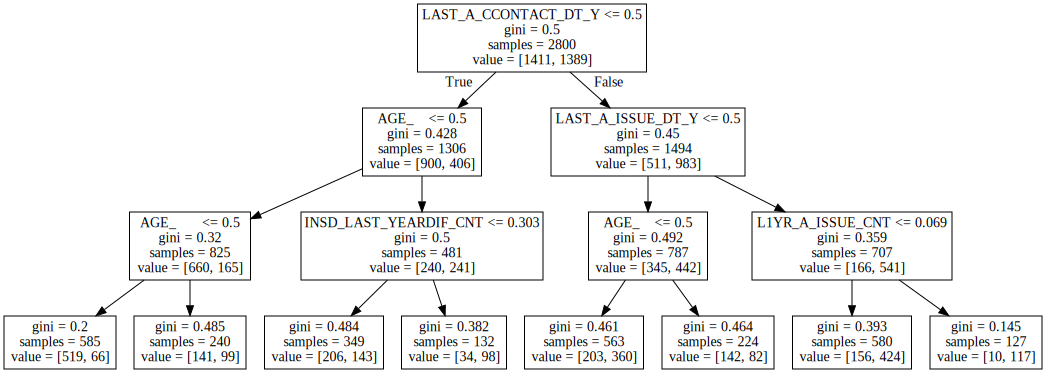

In [27]:
graphviz.Source(tree_graph)

In [28]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

In [29]:
feature_names = x_train.columns.tolist()


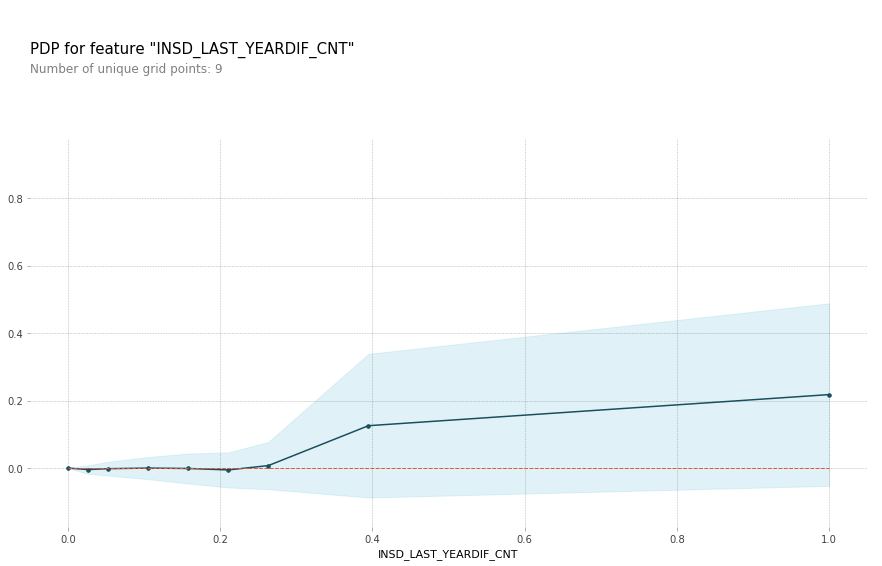

In [30]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model, dataset=x_valid, model_features=feature_names, feature='INSD_LAST_YEARDIF_CNT')

# plot it
pdp.pdp_plot(pdp_goals, 'INSD_LAST_YEARDIF_CNT')
plt.show()

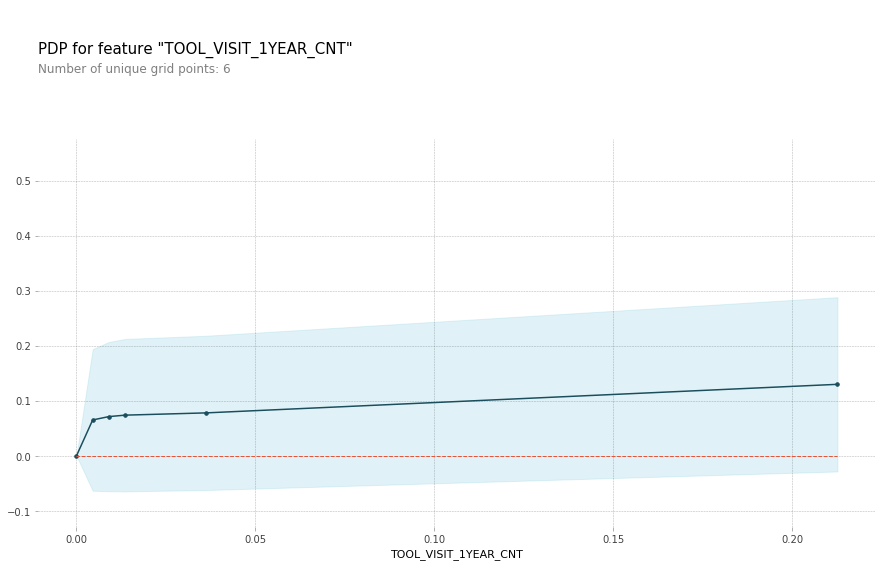

In [31]:
feature_to_plot = 'TOOL_VISIT_1YEAR_CNT'
pdp_dist = pdp.pdp_isolate(model=model, dataset=x_valid, model_features=feature_names, feature=feature_to_plot)

pdp.pdp_plot(pdp_dist, feature_to_plot)
plt.show()

In [32]:
# Similar to previous PDP plot except we use pdp_interact instead of pdp_isolate and pdp_interact_plot instead of pdp_isolate_plot
features_to_plot = ['INSD_LAST_YEARDIF_CNT', 'TOOL_VISIT_1YEAR_CNT']
inter1  =  pdp.pdp_interact(model=model, dataset=x_valid, model_features=feature_names, features=features_to_plot)



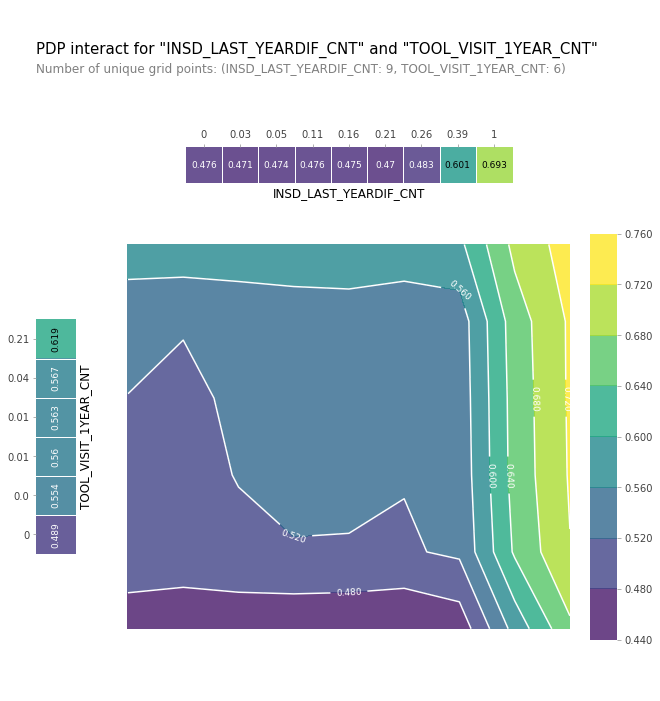

In [33]:
pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour', plot_pdp=True)
plt.show()

In [34]:
import shap

In [35]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid)

In [36]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 
myfont = FontProperties(fname=r'/home/fio/Python/set_up_file/NotoSansCJK-Regular.ttc')

In [37]:
plt.rcParams['font.sans-serif'] = ['NotoSansCJK-Regular', 'NotoSansCJK-Regular']

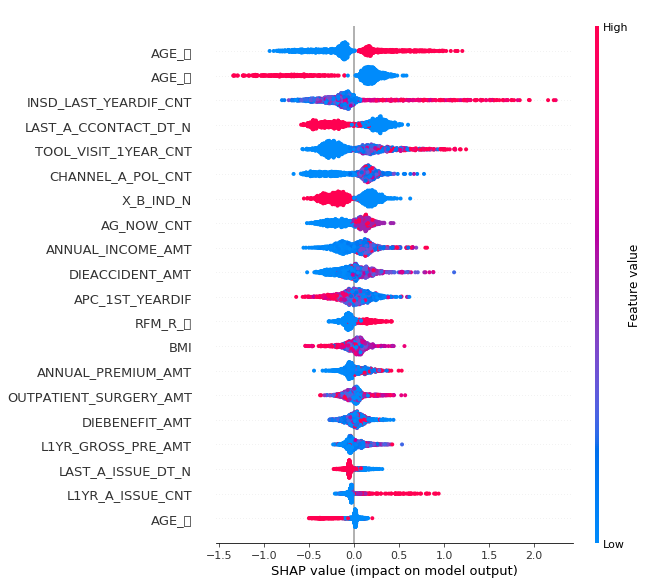

In [38]:
shap.summary_plot(shap_values, x_valid)

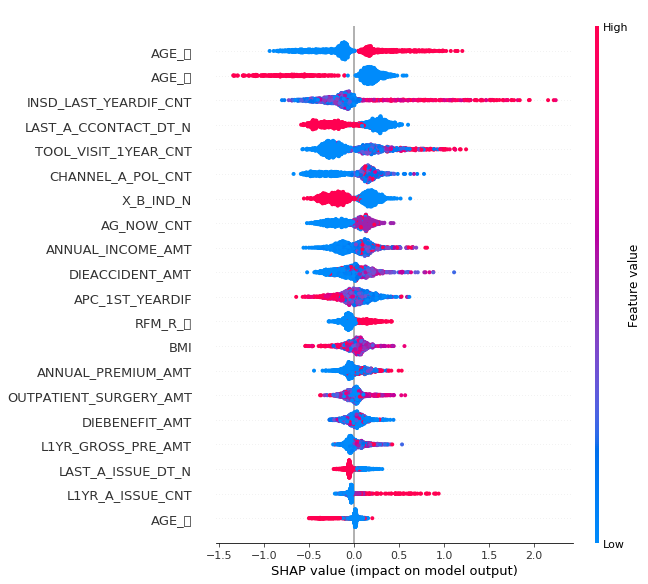

In [39]:
shap.summary_plot(shap_values, x_valid)

In [40]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid)

In [41]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 
myfont = FontProperties(fname=r'/home/fio/Python/set_up_file/NotoSansCJK-Regular.ttc')

In [44]:
model = RandomForestClassifier(random_state=0).fit(train_x, train_y)

row_to_show = 5
data_for_prediction = x_valid.iloc[row_to_show]  
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)


model.predict_proba(data_for_prediction_array)

array([[0., 1.]])

In [45]:
import shap  

data_for_prediction = x_valid.iloc[8,:]  


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], data_for_prediction)